<a href="https://colab.research.google.com/github/MariosGvr/Pytorch-notebooks-and-resources/blob/main/02_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Classification Exercises



In [5]:
# Import torch
import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Available device:',device)

# Setup random seed
RANDOM_SEED = 42

Available device: cuda


## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors. 
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [21]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X_moon, y_moon = make_moons(n_samples=1000,
           noise=0.05,
           random_state=42)

In [8]:
X_moon[:10]

array([[-0.02137124,  0.40618608],
       [ 0.97670045, -0.45832306],
       [ 0.90405882, -0.37651952],
       [ 0.37736316, -0.39703717],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267],
       [ 1.6201408 , -0.28758856],
       [ 0.68246733,  0.80712069]])

In [13]:
# Turn data into a DataFrame
import pandas as pd
moons = pd.DataFrame({
    'X1' : X_moon[:,0],
    'X2' : X_moon[:,1],
    'label' : y_moon
})
moons.head()

,X1,X2,label
0,-0.021371,0.406186,1
1,0.976700,-0.458323,1
2,0.904059,-0.376520,1
3,0.377363,-0.397037,1
4,-0.841926,0.530587,0


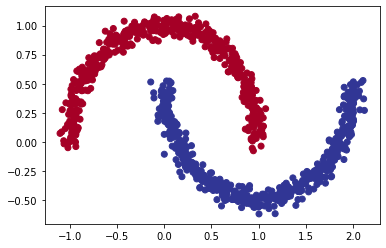

In [18]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter(x=moons['X1'], #X_moon[:,0],
            y=moons['X2'], #X_moon[:,1],
            c=moons['label'],
            cmap=plt.cm.RdYlBu);

In [55]:
# Turn data into tensors of dtype float
X = torch.tensor(X_moon).type(torch.float)
y = torch.tensor(y_moon).type(torch.float)

# Alternatively
# X = torch.from_numpy(X_moon).type(torch.float)
# y = torch.from_numpy(y_moon).type(torch.LongTensor)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [52]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=10):

        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.layer_stack(x)

# Instantiate the model
model_0 = MoonModelV0(
    input_features = 2,
    output_features = 1,
    hidden_units = 8
).to(device)

model_0

MoonModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [53]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters

optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.01)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [54]:
# What's coming out of our model?
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device)).squeeze() 
# logits (raw outputs of model)
print("Logits:")
print(y_logits[:10])

# Prediction probabilities
print("Pred probs:")
y_preds = torch.sigmoid(y_logits)
print(y_preds[:10])

# Prediction labels
print("Pred labels:")
y_labels = torch.round(y_preds)
print(y_labels[:10])

Logits:
tensor([-0.2463, -0.2414, -0.2419, -0.2398, -0.2577, -0.2602, -0.2454, -0.2449,
        -0.2422, -0.2416], device='cuda:0')
Pred probs:
tensor([0.4387, 0.4399, 0.4398, 0.4403, 0.4359, 0.4353, 0.4390, 0.4391, 0.4397,
        0.4399], device='cuda:0')
Pred labels:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [46]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

# TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task='binary').to(device) # send accuracy function to device
acc_fn

BinaryAccuracy()

In [56]:
# TODO: Uncomment this to set the seed
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 100

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (logits output)
    y_logits = model_0(X_train).squeeze() 
    ## Turn logits into prediction probabilities and then into prediction labels
    y_pred = torch.round(torch.sigmoid(y_logits))   
    
    # 2. Calculaute the loss
    loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs
    
    ## Calculate the accuracy
    acc = acc_fn(y_pred, y_train) # the accuracy function needs to compare pred labels (not logits) with actual labels
    
    # 3. Zero the gradients
    optimizer.zero_grad()
    
    # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
    loss.backward()

    # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression) 
    optimizer.step()
    
    ### Testing
    model_0.eval() 
    with torch.inference_mode():
        # 1. Forward pass (to get the logits)
        y_test_logits = model_0(X_test).squeeze() 
        ## Turn the test logits into prediction labels
        y_test_pred = torch.round(torch.sigmoid(y_test_logits)) 
    
        # 2. Caculate the test loss/acc
        test_loss = loss_fn(y_test_logits, y_test) # loss = compare model raw outputs to desired model outputs
        test_acc = acc_fn(y_test_pred, y_test) # the accuracy function needs to compare pred labels (not logits) with actual labels
    
    # Print out what's happening every 100 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Acc: {acc:.2f} | Test Loss: {test_loss:.2f}, Test Acc: {test_acc:.2f}")  

Epoch: 0 | Loss: 0.70, Acc: 0.50 | Test Loss: 0.70, Test Acc: 0.50
Epoch: 10 | Loss: 0.66, Acc: 0.72 | Test Loss: 0.66, Test Acc: 0.68
Epoch: 20 | Loss: 0.57, Acc: 0.77 | Test Loss: 0.57, Test Acc: 0.74
Epoch: 30 | Loss: 0.43, Acc: 0.81 | Test Loss: 0.44, Test Acc: 0.80
Epoch: 40 | Loss: 0.31, Acc: 0.85 | Test Loss: 0.31, Test Acc: 0.83
Epoch: 50 | Loss: 0.24, Acc: 0.89 | Test Loss: 0.23, Test Acc: 0.90
Epoch: 60 | Loss: 0.21, Acc: 0.90 | Test Loss: 0.20, Test Acc: 0.91
Epoch: 70 | Loss: 0.18, Acc: 0.92 | Test Loss: 0.17, Test Acc: 0.93
Epoch: 80 | Loss: 0.12, Acc: 0.95 | Test Loss: 0.11, Test Acc: 0.96
Epoch: 90 | Loss: 0.05, Acc: 0.99 | Test Loss: 0.04, Test Acc: 1.00


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [48]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):
  
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/ 
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

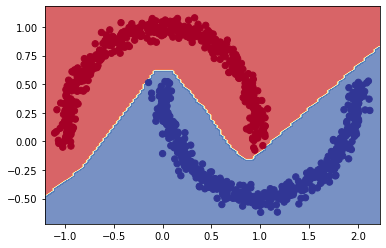

In [57]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_0, X, y)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

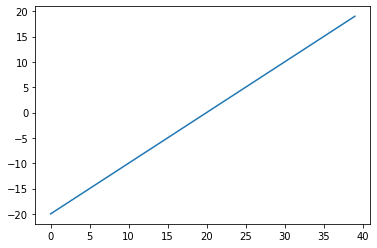

In [65]:
# Create a straight line tensor
line_tensor = torch.arange(-20, 20, 1)
plt.plot(line_tensor);

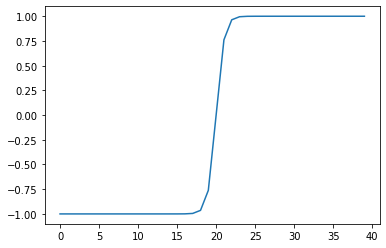

In [64]:
# Test torch.tanh() on the tensor and plot it
tahn = torch.tanh(line_tensor)
plt.plot(tahn);

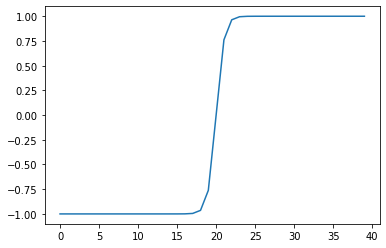

In [68]:
# Replicate torch.tanh() and plot it
plt.plot(np.tanh(line_tensor));

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

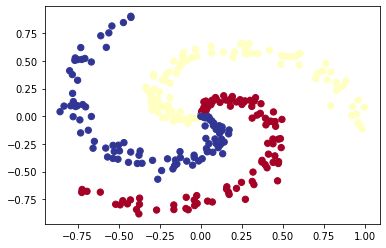

In [88]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
  
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [70]:
X[:10], y[:10]

(array([[0.        , 0.        ],
        [0.0001288 , 0.01010019],
        [0.00421814, 0.01975674],
        [0.01251715, 0.027597  ],
        [0.00462762, 0.04013816],
        [0.0078066 , 0.04989807],
        [0.03210406, 0.05140451],
        [0.029881  , 0.06408288],
        [0.01837029, 0.0786923 ],
        [0.04134551, 0.08096302]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [89]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [76]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy, MatthewsCorrCoef

acc_fn = Accuracy(task='multiclass', num_classes=3).to(device)
mcc_fn = MatthewsCorrCoef(task='multiclass', num_classes=3).to(device)

In [90]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class MultiMoonModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=10):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.layer_stack(x)

# Instantiate model and send it to device
model_1 = MultiMoonModel(
    input_features=2,
    output_features=3,
    hidden_units=8
).to(device)

model_1

MultiMoonModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [ ]:
# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Print out first 10 untrained model outputs (forward pass)
print("Logits:")
model_1.eval()
with torch.inference_mode():
    y_logits = model_1(X_train[:10])
print(y_logits)

print("Pred probs:")
y_preds = torch.softmax(y_logits, dim=1)
print(y_preds)

print("Pred labels:")
y_labels = torch.argmax(y_preds, dim=1)
print(y_labels)

In [92]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.01
    )

In [93]:
# Build a training loop for the model
epochs = 500
# Loop over data
for epoch in range(epochs):
    ## Training
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train)
    y_labels = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_labels, y_train)
    #mcc = mcc_fn(y_labels, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ## Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        y_test_logits = model_1(X_test)
        y_test_labels = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

        # 2. Caculate loss and acc
        test_loss = loss_fn(y_test_logits, y_test)
        test_acc = acc_fn(y_test_labels, y_test)
        test_mcc = mcc_fn(y_test_labels, y_test)    
    
    # Print out what's happening every 100 epochs
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f}, Acc: {acc:.2f} | Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}, Test MCC: {test_mcc:.2f}")

Epoch: 0 | Loss: 1.11, Acc: 0.32 | Test loss: 1.11, Test acc: 0.37, Test MCC: 0.00
Epoch: 50 | Loss: 0.86, Acc: 0.66 | Test loss: 0.87, Test acc: 0.58, Test MCC: 0.44
Epoch: 100 | Loss: 0.54, Acc: 0.73 | Test loss: 0.60, Test acc: 0.63, Test MCC: 0.46
Epoch: 150 | Loss: 0.41, Acc: 0.83 | Test loss: 0.45, Test acc: 0.85, Test MCC: 0.77
Epoch: 200 | Loss: 0.22, Acc: 0.93 | Test loss: 0.21, Test acc: 0.97, Test MCC: 0.95
Epoch: 250 | Loss: 0.12, Acc: 0.97 | Test loss: 0.10, Test acc: 1.00, Test MCC: 1.00
Epoch: 300 | Loss: 0.08, Acc: 0.98 | Test loss: 0.06, Test acc: 1.00, Test MCC: 1.00
Epoch: 350 | Loss: 0.07, Acc: 0.98 | Test loss: 0.04, Test acc: 1.00, Test MCC: 1.00
Epoch: 400 | Loss: 0.06, Acc: 0.98 | Test loss: 0.03, Test acc: 1.00, Test MCC: 1.00
Epoch: 450 | Loss: 0.05, Acc: 0.98 | Test loss: 0.02, Test acc: 1.00, Test MCC: 1.00


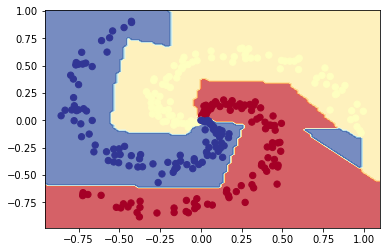

In [94]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_1, X, y)